## Segment a sparse 3D image with a single material component  

The goal of this notebook is to develop a 3D segmentation algorithm that improves segmentation where features are detected.

**Data:** AM parts from Xuan Zhang. 

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import cupy as cp
from tomo_encoders.misc import viewer
from tomo_encoders import DataFile, Grid
from skimage.filters import threshold_otsu
from tomo_encoders.reconstruction.recon import recon_binning
import h5py
import sys
import time
import vedo

In [2]:
pixel_res = 1.17 # micrometer per pixel
b = 4
b_K = 4
wd = 32

In [4]:
hf = h5py.File('/data02/MyArchive/aisteer_3Dencoders/tmp_data/projs_2k.hdf5', 'r')
projs = np.asarray(hf["data"][:])
theta = np.asarray(hf['theta'][:])
center = float(np.asarray(hf["center"]))
hf.close()

In [5]:
sys.path.append('/home/atekawade/TomoEncoders/scratchpad/voids_paper')
from surface_determination import Voids

	TIME reconstructing with binning - 0.55 secs
voids found: 21077
	STAT: r value: 3.43
	STAT: size thres: 4.27 pixel length
time checkpoint 2.33 secs


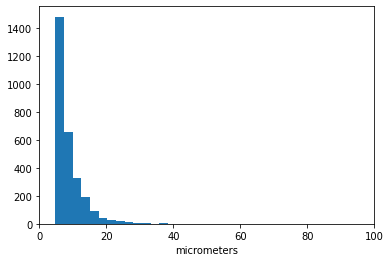

In [6]:
size_thresh = 20.0/(b*pixel_res)
st_chkpt = cp.cuda.Event(); end_chkpt = cp.cuda.Event(); st_chkpt.record()    
voids_b = Voids().guess_voids(projs, theta, center, b, b_K)    
# voids_b.select_by_size(size_thresh)
void_id = np.argsort(voids_b["sizes"])[-2]
pix_radius = int(np.cbrt(voids_b["sizes"][void_id])*2)
voids_b.select_around_void(void_id, pix_radius)
p_sel, r_fac = voids_b.export_grid(wd//b)
p_sel = p_sel.rescale(b)
print(f'\tSTAT: size thres: {size_thresh:.2f} pixel length')
end_chkpt.record(); end_chkpt.synchronize(); t_chkpt = cp.cuda.get_elapsed_time(st_chkpt,end_chkpt)
print(f"time checkpoint {t_chkpt/1000.0:.2f} secs")

plt.hist(np.cbrt(voids_b["sizes"])*pixel_res*b, bins = 100)
plt.xlabel("micrometers")        
plt.xlim([0,100])
cp.fft.config.clear_plan_cache()

In [7]:
surf = voids_b.export_surface()

	TIME: export surface 2.19 secs


In [8]:
from tomo_encoders.mesh_processing.vox2mesh import save_ply

In [9]:
save_ply('/home/atekawade/Dropbox/Arg/transfers/runtime_plots/mesh_1.ply', surf["vertices"], surf["faces"])

In [10]:
len(voids_b)

2872

In [11]:
test = np.zeros((10,30,20))
from scipy.ndimage import label
a, b = label(test)
b

0

In [12]:
type(surf)

surface_determination.Surface